In [ ]:
## We will plot Fourier Sensitivity plots for ImageNet pre-trained models from TIMM (https://rwightman.github.io/pytorch-image-models/) ###

In [ ]:
### Import libraries ###

In [1]:
import os
import numpy as np
import sys
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft

import torchvision
from torchvision import transforms
from torchvision import datasets as torchvision_datasets

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

%matplotlib inline 
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
### Define helper functions to plot Fourier Sensitivity ###

In [22]:
def rotavg(image):
    """
    Computes radial average at each distinct radius from centre.
    input is power spectral matrix
    """
    assert (image.shape[0] == image.shape[1]) and (image.shape[0] % 2 == 0), 'image must be square and even'

    L=np.arange(-image.shape[1]/2,image.shape[1]/2) # [-N/2, ... 0, ... N/2-1]
    x,y = np.meshgrid(L, L)
    R = np.round(np.sqrt(x**2+y**2))
    
    f = lambda r : image[R==r].sum()
    
    r  = np.unique(R)
    r = r[1:] # exclude DC component
    outputs = np.vectorize(f)(r)
    
    outputs /= outputs.sum()
        
    return outputs

def plot_spectrum(im, ylim=1, return_data=False, save=False, title=False):
    """
    plot image spectrum as described in "Natural Image Statistics" (Hyvärinen et al.) pg. 117
    """
    vectors = []
    
    # input can be (N, c, h, w) or (N, h, w) or [ (h,w) .. (h,w) ] or [ (c,h,w), ... ]
    if hasattr(im, 'shape'):
        assert len(im.shape)==4, 'must be shape "(N,C,H,W)"'
        num_samples = im.shape[0]
            
    else:
        num_samples = len(im)
     
    R, radial_indices=None,None
    low_energy_sums, med_energy_sums, high_energy_sums=[],[],[]
    
    for _ in range(num_samples):
        im1 = im[_]
        
        # average channels, (C, H, W) -> (H,W) 
        if len(im1.shape) == 3: 
            im1=torch.mean(im1,axis=0)

        # rotavg expects even shaped input
        # if even shaped, pad width and height by 1 each
        if im1.shape[0] % 2 == 1:
            im1 = F.pad(im1,(0,1,0,1))

        # size of image
        fouriersize = im1.shape[1]
        
        # Partly adapted from code by Bruno Olshausen
        im1f=np.fft.fftshift(torch.fft.fftn(im1, norm='ortho').numpy())
        im1_ph = np.angle(im1f, deg=True) # phase
        im1_pf=np.abs(im1f)**2 # power
            
        f=np.arange(-fouriersize/2, fouriersize/2)

        Pf1=rotavg(im1_pf) # power ratios in [1, ... , 23]
        freq = np.arange(1, len(Pf1)+1)  # [1, ..., 23] for cifar.  

        vectors.append(Pf1)

    mean_vector = np.mean(vectors, axis=0)
    
    x_label, y_label = 'Spatial Frequency (cycles/image)', 'Total Power Ratio'
        
    data = []

    for vector in vectors:
        for _ in range(len(freq)):
            data.append([freq[_], vector[_]]) # data=[ [x1,y1], [x2, y2] .. ]. data points with same x co-ordinate will be aggregated by seaborn

    df = pd.DataFrame(data, columns=[x_label, y_label])

    # source: https://stackoverflow.com/questions/52525476/seaborn-lineplot-using-median-instead-of-mean
    with plt.style.context('seaborn'):
        sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

        sns.lineplot(data=df, x=x_label, y=y_label, estimator=np.mean, ci='sd')

        plt.xlabel(x_label, fontsize=16);
        plt.ylabel(y_label, fontsize=16);
        plt.ylim([0, ylim])

        if title: plt.title(title, fontfamily='Helvetica', fontsize=20)

        if save: plt.savefig(save.replace('.ckpt', '.svg'), format='svg')

        plt.show()

    if return_data: return df

def get_input_jacobian(model, inp, label):
    """
    compute input-loss jacobian
    """
    inp.requires_grad = True
    output = model(inp)
    
    if type(output) is tuple:
        pred, final_inp = output
    else:
        pred = output
        
    loss = nn.CrossEntropyLoss()(pred, label)
    dloss_dinp = torch.autograd.grad(loss, inp, create_graph=True)[0].detach().cpu()
    
    return dloss_dinp

def plot_sfs(model, data_loader, return_data=False, ylim=1, num_samples=1000, jacobian=True, save=False, title=False):
    """
    Plot Fourier sensitivity of one model
    """
    model.eval()
    
    input_jacobians = None
    
    for idx, (inp, label) in enumerate(data_loader):
        inp = inp.cuda()
        label = label.cuda()
        
        input_jacobian = get_input_jacobian(model, inp, label)            
        
        if input_jacobians is None:
            input_jacobians = input_jacobian
        else:
            input_jacobians = torch.cat((input_jacobians, input_jacobian), dim=0)
        
        if idx * inp.shape[0] > num_samples:
            break
    
    flatten_jacobian = input_jacobians.flatten(start_dim=1, end_dim=3) # convert (N,C,H,W) -> (N, C*H*W)
    jacobian_norms = torch.norm(flatten_jacobian, dim=1)  # convert (N,C*H*W) -> (N)
    avg_jacobian_norm = torch.mean(jacobian_norms) # (1)
    
    input_jacobians = input_jacobians.detach()
    data = plot_spectrum(input_jacobians, return_data=return_data, ylim=ylim, save=save, title=title)
    
    return data

def plot_multiple_sfs(data, save=None, ylim=1, title=None, plot_sd=True, linewidth=1.5):
    """
    plot multiple Fourier sensitivities in one plot
    if plot_sd == False, standard deviation shaded area will not be drawn
    """
    import seaborn as sns
    import pandas as pd
    
    x_label, y_label = 'Spatial Frequency (cycles/image)', 'Total Power Ratio'

    # source: https://stackoverflow.com/questions/52525476/seaborn-lineplot-using-median-instead-of-mean
    with plt.style.context('seaborn'):
        sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})
    
        for df in data:
            sns.lineplot(data=df[0], x=x_label, y=y_label, label=df[1], linestyle='-', \
                         estimator=np.mean, ci='sd' if plot_sd else None, linewidth=linewidth) # 'sd' = std_dev

        plt.xlabel(x_label, fontsize=16);
        plt.ylabel(y_label, fontsize=16);
        plt.ylim([0, ylim])

        plt.legend(prop={'size': 14}) # legend fontsize

        if title:
            plt.title(title, fontfamily='Helvetica', fontsize=20) # title font size

        if save:
            plt.savefig(save.replace('.ckpt', '.svg'), format='svg')
        
        plt.show()

In [3]:
## See this page for a list of available models: https://rwightman.github.io/pytorch-image-models/models/

In [5]:
## Set PATH_TO_IMAGENET to the path to the ImageNet dataset on your machine 

In [6]:
PATH_TO_IMAGENET = '/home/kiran/datasets/imagenet'

In [7]:
## helper functions to load TIMM model and corresponding dataloader

In [11]:
PLOT_DATA = {} # store data to plot all in one plot

def get_timm_imagenet_loader(model):
    timm_config = resolve_data_config({}, model=model)
    # set input size to 224, some models like inception and BiT have bigger input sizes
    timm_config['input_size'] = (3, 224, 224)
    
    timm_transform = create_transform(**timm_config)
    
#     print(timm_transform)
#     print(timm_config)
    
    # use these loaders from timm models (requires mean-std normalization in the loader itself)
    timm_imagenet_data = torchvision.datasets.ImageNet(PATH_TO_IMAGENET, 
                                                  split='val', 
                                                  transform=timm_transform)

    timm_imagenet_loader = torch.utils.data.DataLoader(timm_imagenet_data,
                                              batch_size=1, 
                                              shuffle=True)
    return timm_imagenet_loader

def generate_timm_model_sfs(timm_model_name):
    model = timm.create_model(timm_model_name, pretrained=True)
    model = model.cuda()
    model.eval()
    
    # num_samples is the number of samples used to estimate Fourier-sensitivity
    # ylim is the maximum y-axis value
    PLOT_DATA[timm_model_name]=plot_sfs(model, get_timm_imagenet_loader(model), return_data=True, ylim=0.04, num_samples=100)
    del model

In [12]:
# Plot Fourier Sensitivities!

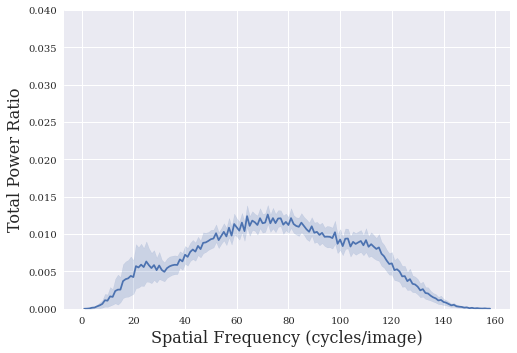

In [13]:
# BiT Transfer model: https://rwightman.github.io/pytorch-image-models/models/big-transfer/
generate_timm_model_sfs('resnetv2_101x1_bitm')

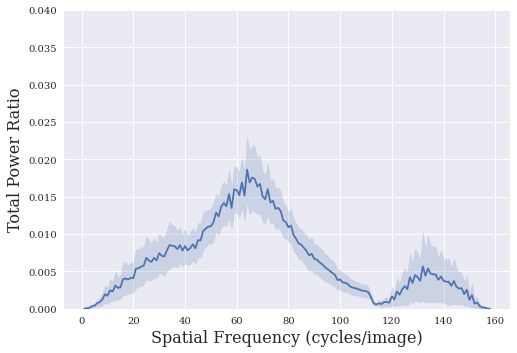

In [14]:
# Vision Transformer (ViT) https://rwightman.github.io/pytorch-image-models/models/vision-transformer/
generate_timm_model_sfs('vit_base_patch16_224')

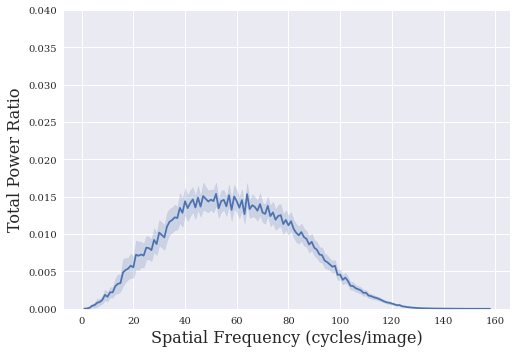

In [16]:
# https://rwightman.github.io/pytorch-image-models/models/inception-v3/
generate_timm_model_sfs('inception_v3')

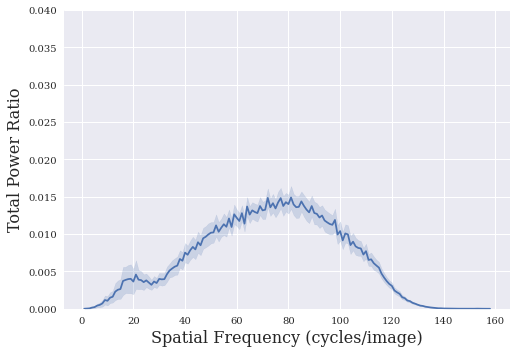

In [17]:
# https://rwightman.github.io/pytorch-image-models/models/resnet/
generate_timm_model_sfs('resnet18')

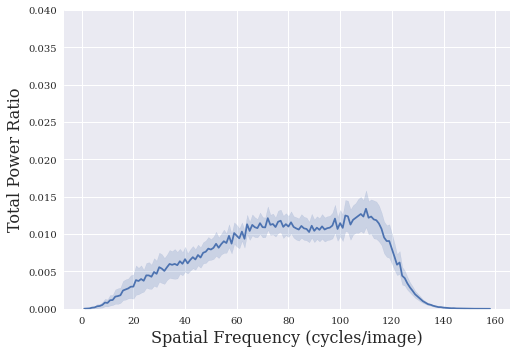

In [20]:
# https://rwightman.github.io/pytorch-image-models/models/mixnet/
generate_timm_model_sfs('mixnet_l')

In [ ]:
## Multiple plots in one

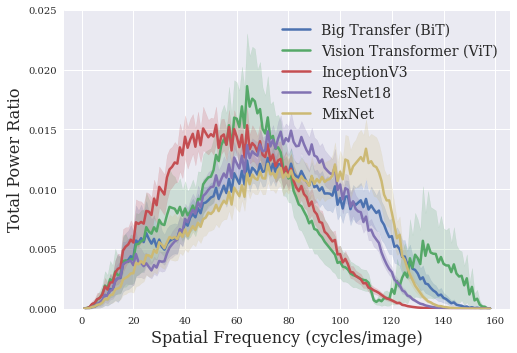

In [23]:
data = [
        [PLOT_DATA['resnetv2_101x1_bitm'], 'Big Transfer (BiT)'],
        [PLOT_DATA['vit_base_patch16_224'], 'Vision Transformer (ViT)'],
        [PLOT_DATA['inception_v3'], 'InceptionV3'],
        [PLOT_DATA['resnet18'], 'ResNet18'],
        [PLOT_DATA['mixnet_l'], 'MixNet'],
       ]

# set plot_sd=False to remove the shaded area in the plot
# use the 'save' parameter to save figure
# ylim is the y-axis maximum height
plot_multiple_sfs(data, ylim=0.025, save='timm_models.svg', plot_sd=True, linewidth=2.5)